In [2]:
import os
import json
import zipfile
import requests
from urllib.request import urlretrieve

import pandas as pd
import re
import glob
import time


## Download Data

In [2]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}/versions/3"
headers = {"Content-Type": "application/json"}


response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)["files"]

download_url = [item["download_url"] for item in data if item["name"] == "data.zip"][0]
download_url

output_directory = "data/"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
urlretrieve(download_url, output_directory + "rainfall.zip")

with zipfile.ZipFile(os.path.join(output_directory, "rainfall.zip"), 'r') as f:
    f.extractall(output_directory)
# output_directory = "figshareairline/"

## Combine CSV

### Combine all the CSVs using Python

In [3]:
%%time
files = glob.glob("data/*.csv")
files.remove("data\\observed_daily_rainfall_SYD.csv")
df = pd.concat(
    (pd.read_csv(file, index_col=0, parse_dates=['time'])
     .assign(model=re.findall(r'[^\/&\\]+(?=_daily_rainfall_NSW\.)', file)[0])
        )
     for file in files
)
df.to_csv("data/combined_data.csv")


CPU times: total: 8min 56s
Wall time: 9min 1s


In [4]:
df.head(5)

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


#### Combine CSVs Time taken in each machine



| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    8min    |
| Andy        |    Windows 10    | 16GB| Intel i7  |   Y    |  8min 36s  |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

## Observations

In [5]:
%load_ext memory_profiler

Wall time: 1min 11s


<AxesSubplot:>

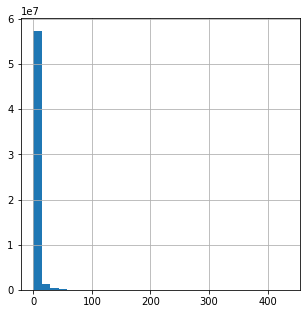

In [6]:
%%time
df = pd.read_csv("data/combined_data.csv", index_col=0)
df["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    1:41    |
| Andy        |    Windows 10    | 16GB| Intel i7  |   Y    |    1:11    |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Approach 1: Change the data type**

In [7]:
print(f"float64 memory usage: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"float32 memory usage: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

float64 memory usage: 2998.46 MB
float32 memory usage: 1749.10 MB


peak memory: 5783.84 MiB, increment: 2348.91 MiB
Wall time: 3.79 s


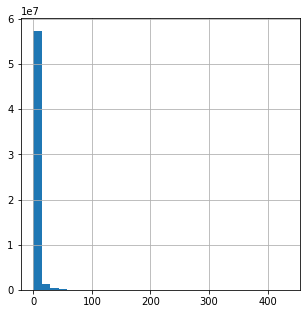

In [8]:
%%time
%%memit
df_dtype = df.astype({'lat_min': 'float32',
                      'lat_max': 'float32',
                      'lon_min': 'float32',
                      'lon_max': 'float32',
                      'rain (mm/day)': 'float32'})
df_dtype["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    15s     |
| Andy        |    Windows 10    | 16GB| Intel i7  |   Y    |    3.8s    |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Observations**

- Changing the data type from float64 to float32 drastically improved the time taken from almost 2 minutes to mere 15 seconds
- Changing the data type also reduced the memory usage by half, which is a lot of saved memory!

**Loading all the necessary columns**


%%time
%%memit
useful_cols = ['time','rain (mm/day)']
df_columns = pd.read_csv("data/combined_data.csv",usecols=useful_cols)
df_columns["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |     1min   |
| Andy        |    Windows 10    | 16GB| Intel i7  |   Y    |    48.8s   |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Observations**

Loading only the necessary columns reduced the processing time down to 1min (from 1min 40s). However, this is not as large of a improvement than changing the data type.

## Python to R

### Transfer Using Parquet File

Data was transferred from Python to R using the Parquet data format. This format was chosen because of its widespread use and consistency, in addition to it's advantages over traditional CSV formats such as data partitioning, projection and predicate pushdown. It is easy to use with rarrow, making reading the parquet file into R easy and quick. Transferring the data into a parquet file also ensures that there are no limitations on dataframe transfer sizes from python to R, as can be encountered when using pandas exchange. Notably, the Parquet file is also usable for additional applications outside of python to R transfer, and is stable for such use cases unlike Feather.

In [ ]:
df.to_parquet("data/combined_rainfall_data.parquet", partition_cols=['model'])

In [4]:
%load_ext rpy2.ipython

C:\Users\andy8\miniconda3\envs\525_2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [5]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(ggplot2, warn.conflicts = FALSE))

df_R <- open_dataset("data/combined_rainfall_data.parquet")
df_filt <- df_R |>
    select(time, lat_min, lon_min, `rain (mm/day)`) |>
    collect()

head(df_filt)

# A tibble: 6 x 4
  time                lat_min lon_min `rain (mm/day)`
  <dttm>                <dbl>   <dbl>           <dbl>
1 1889-01-01 04:00:00   -36.3    142.        1.29e-24
2 1889-01-02 04:00:00   -36.3    142.        1.28e-24
3 1889-01-03 04:00:00   -36.3    142.        1.50e-17
4 1889-01-04 04:00:00   -36.3    142.        1.01e- 1
5 1889-01-05 04:00:00   -36.3    142.        4.58e- 1
6 1889-01-06 04:00:00   -36.3    142.        6.25e+ 0


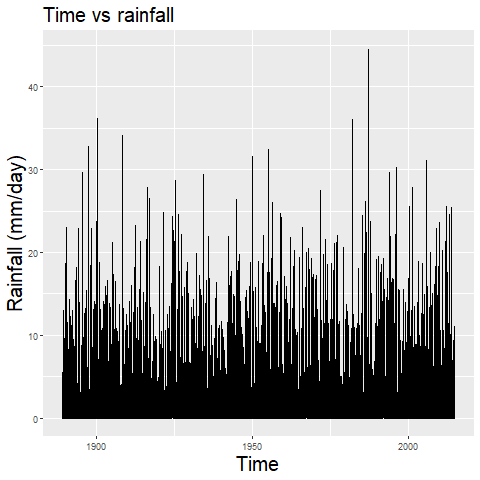

In [11]:
%%R

df_line <- df_filt |>
    group_by(time)|>
    summarize(mean_rainfall = mean(`rain (mm/day)`, na.rm = TRUE))

line_plot <- ggplot(df_line, aes(x = time, y = mean_rainfall)) +
    geom_line() +
    ggtitle("Time vs rainfall") +
    xlab("Time") +
    ylab("Rainfall (mm/day)") + 
    theme(
        axis.title=element_text(size=20),
        plot.title=element_text(size=20)
    )

line_plot

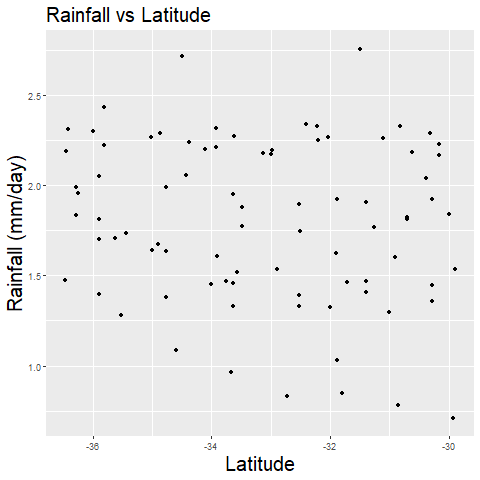

In [12]:
%%R
       
df_lat <- df_filt |>
    group_by(lat_min)|>
    summarize(mean_rainfall = mean(`rain (mm/day)`, na.rm = TRUE))

lat_scatter <- ggplot(df_lat, aes(x = lat_min, y = mean_rainfall)) +
    geom_point() +
    ggtitle("Rainfall vs Latitude") +
    xlab("Latitude") +
    ylab("Rainfall (mm/day)") + 
    theme(
        axis.title=element_text(size=20),
        plot.title=element_text(size=20)
    )

lat_scatter

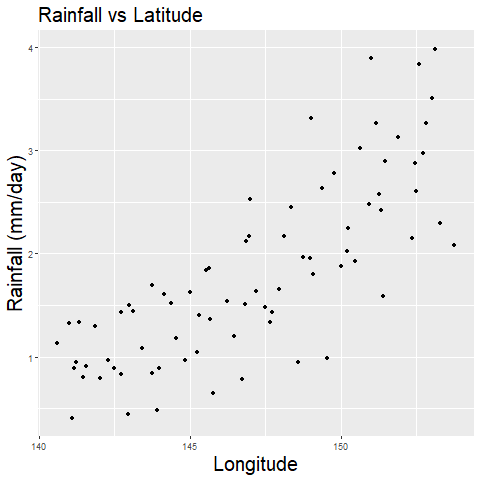

In [13]:
%%R
       
df_lon <- df_filt |>
    group_by(lon_min)|>
    summarize(mean_rainfall = mean(`rain (mm/day)`, na.rm = TRUE))

lon_scatter <- ggplot(df_lon, aes(x = lon_min, y = mean_rainfall)) +
    geom_point() +
    ggtitle("Rainfall vs Latitude") +
    xlab("Longitude") +
    ylab("Rainfall (mm/day)") +
    theme(
        axis.title=element_text(size=20),
        plot.title=element_text(size=20)
    )


lon_scatter

In [ ]:
%%R

hist <- ggplot(df_filt, aes(x = `rain (mm/day)`)) +
    geom_histogram(bin=30) +
    ggtitle("Rainfall distribution") +
    xlab("rainfall (mm/day)") +
    ylab("Number of entries") +
    theme(
        axis.title=element_text(size=20),
        plot.title=element_text(size=20)
    )

hist